In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from bertopic import BERTopic
import nltk
import nltk.corpus
from gensim.models import Word2Vec
import os
from wordcloud import WordCloud
import collections
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

/opt/miniconda3/envs/rosetta/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get words from the text corpus

from nltk.corpus import PlaintextCorpusReader
wordlists = PlaintextCorpusReader('da/processed', '.*')

da_words = []

for file in wordlists.fileids():
        da_words.append(wordlists.words(file))

In [3]:
# get the rosetta data

data_raw = pd.read_excel("rosetta_data_inputs_2023.xls")

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [4]:
# Get main columns and filter rows without headings
data = data_raw[["Overskrift", "Beskrivelse"]]
data = data[data["Overskrift"].notna()]

In [5]:
# remove danish words and prep data for use

def filter_danish(text):
       return " ".join(w.lower() for w in nltk.wordpunct_tokenize(text) 
                       if w.casefold() not in da_words and w.isalpha() and w != 'nan')

# combine heading and description
title_strings = data['Overskrift'].astype('str')
description_strings = data['Beskrivelse'].astype('str')
docs = title_strings + " \n\n" + description_strings

docs = docs.apply(filter_danish)

In [6]:
# tokenize text, keep short tokens and stopwords

def tokenize_text(text, tokenizer):
    tokens = tokenizer(text)  # Get tokens from text
    return tokens

tokens = docs.map(lambda x: tokenize_text(x, nltk.word_tokenize))

### BERT Topic Model

In [7]:
## BERT Topic Model

from sklearn.feature_extraction.text import CountVectorizer

# Remove stopwords after documents are assigned to topics
# Allows the transformer model to get the full context of the 
# data, while removing stopwords that are noise in the topics
vectorizer_model = CountVectorizer(stop_words="english")

# Define and train the model
topic_model = BERTopic(nr_topics=20, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info() 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1179,-1_use_water_heat_used,"[use, water, heat, used, cup, using, make, leg...",[a triangle shaped cup made of grassseeds pres...
1,0,792,0_window_cups_windows_plastic,"[window, cups, windows, plastic, glands, glass...",[hybrid window combine old windows with new ma...
2,1,569,1_detect_weeds_toilet_use,"[detect, weeds, toilet, use, sensors, urine, t...",[biosensor biological sensor a biosensor is a ...
3,2,538,2_tank_fish_chickens_ground,"[tank, fish, chickens, ground, robot, drone, t...",[hybrid engines hybrid engines could be used t...
4,3,372,3_heat_wind_turbine_pumice,"[heat, wind, turbine, pumice, turbines, waste,...",[combine a heat pump to a small scale wind tur...
5,4,300,4_protein_powder_whey_potatoes,"[protein, powder, whey, potatoes, high, pulp, ...",[high pressure homogenizers high pressure homo...
6,5,228,5_esg_employees_employee_sustainability,"[esg, employees, employee, sustainability, fas...",[physical event planner platform pepp a platfo...
7,6,220,6_chair_table_bed_elderly,"[chair, table, bed, elderly, matress, chairs, ...",[assumption future no care workers fully autom...
8,7,209,7_board_gypsum_boards_wall,"[board, gypsum, boards, wall, holes, screws, c...",[magnet loosens the gypsum board the boards is...
9,8,193,8_oven_pizza_buns_bread,"[oven, pizza, buns, bread, rolls, different, r...",[big pizza oven make the pizza oven bigger sti...


## BERTopic Analysis

In [8]:
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model.save("bertopic_model", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [9]:
topic_model.visualize_topics()

In [21]:
def get_topic_dict(num):
        topic = topic_model.get_topic(num)
        topic_dict = {}

        for word in topic:
                topic_dict[word[0]] = word[1]

        return topic_dict

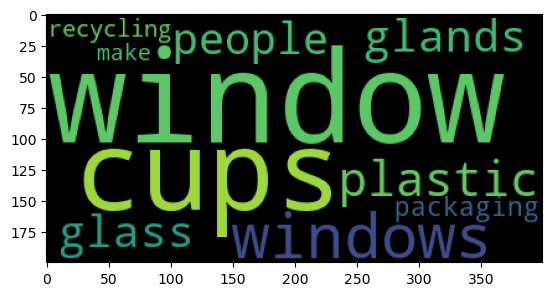

In [23]:
wc = WordCloud().fit_words(get_topic_dict(0))
plt.imshow(wc)

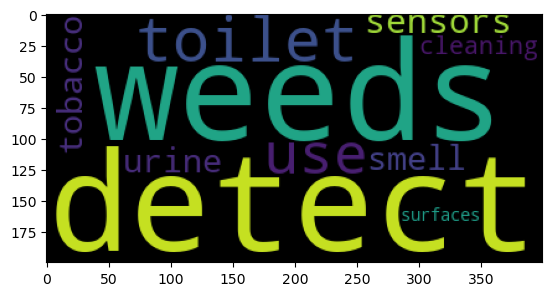

In [24]:
wc = WordCloud().fit_words(get_topic_dict(1))
plt.imshow(wc)

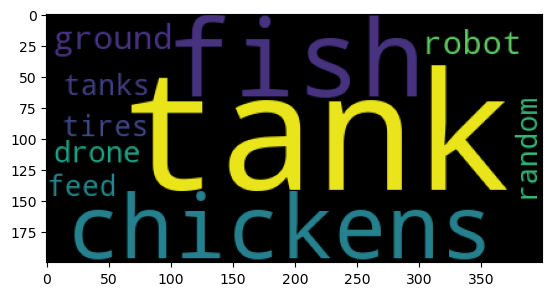

In [25]:
wc = WordCloud().fit_words(get_topic_dict(2))
plt.imshow(wc)

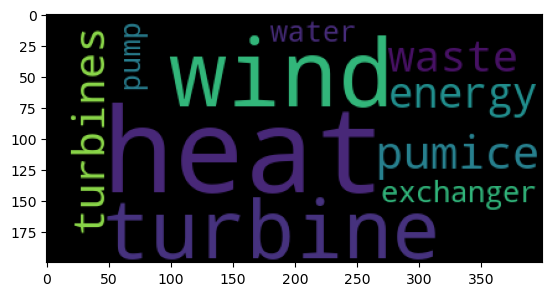

In [26]:
wc = WordCloud().fit_words(get_topic_dict(3))
plt.imshow(wc)

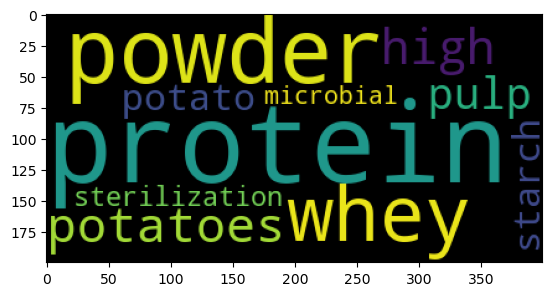

In [27]:
wc = WordCloud().fit_words(get_topic_dict(4))
plt.imshow(wc)

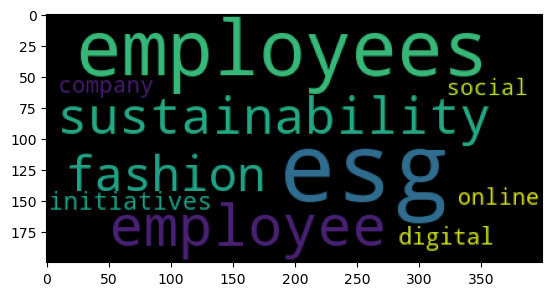

In [28]:
wc = WordCloud().fit_words(get_topic_dict(5))
plt.imshow(wc)

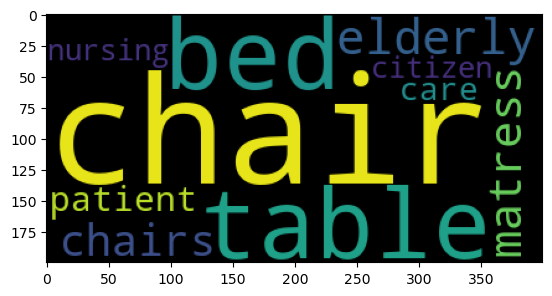

In [29]:
wc = WordCloud().fit_words(get_topic_dict(6))
plt.imshow(wc)

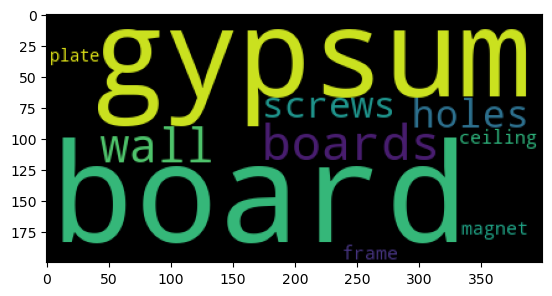

In [30]:
wc = WordCloud().fit_words(get_topic_dict(7))
plt.imshow(wc)

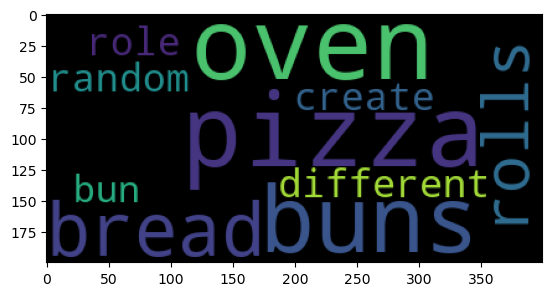

In [31]:
wc = WordCloud().fit_words(get_topic_dict(8))
plt.imshow(wc)

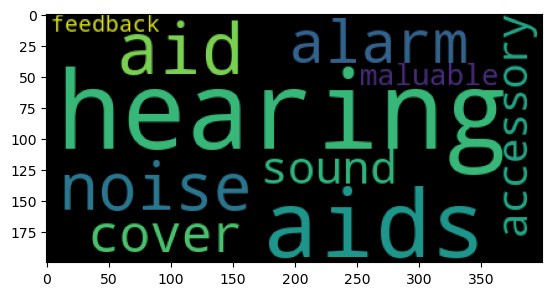

In [32]:
wc = WordCloud().fit_words(get_topic_dict(9))
plt.imshow(wc)

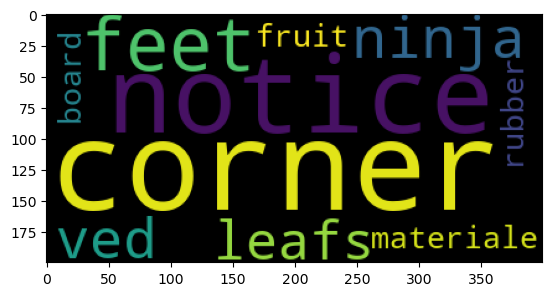

In [33]:
wc = WordCloud().fit_words(get_topic_dict(10))
plt.imshow(wc)

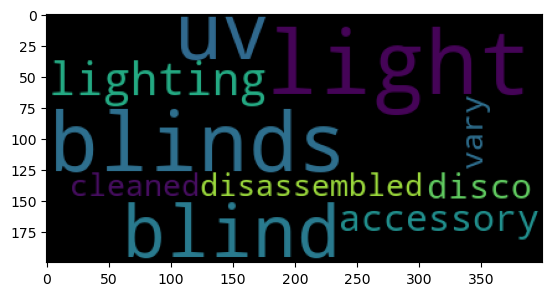

In [34]:
wc = WordCloud().fit_words(get_topic_dict(11))
plt.imshow(wc)

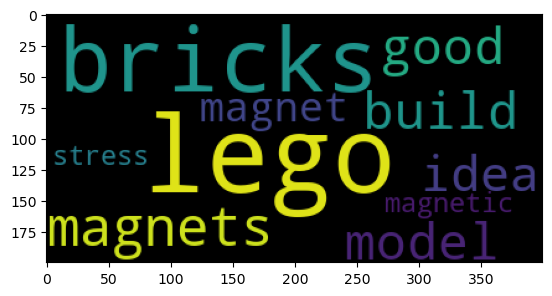

In [35]:
wc = WordCloud().fit_words(get_topic_dict(12))
plt.imshow(wc)

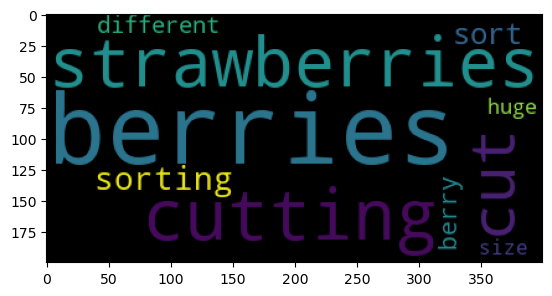

In [36]:
wc = WordCloud().fit_words(get_topic_dict(13))
plt.imshow(wc)

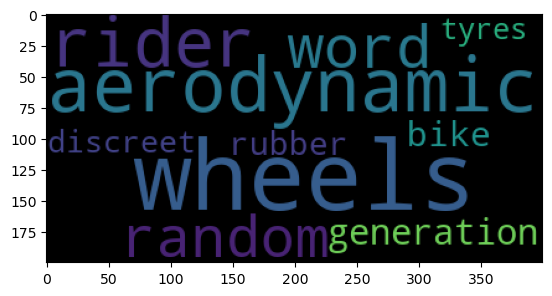

In [37]:
wc = WordCloud().fit_words(get_topic_dict(14))
plt.imshow(wc)

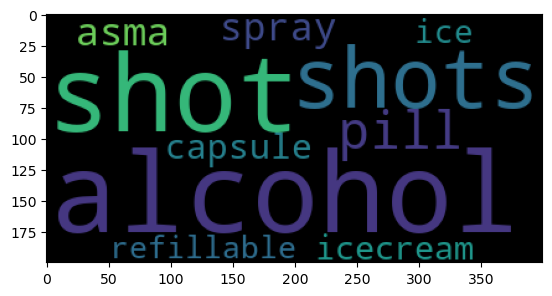

In [38]:
wc = WordCloud().fit_words(get_topic_dict(15))
plt.imshow(wc)

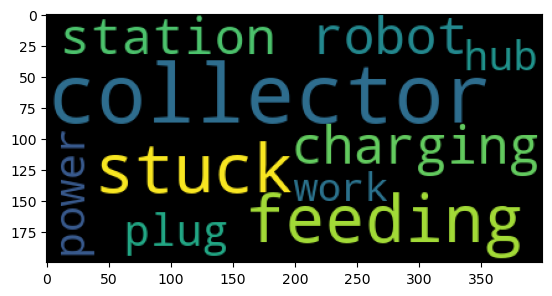

In [39]:
wc = WordCloud().fit_words(get_topic_dict(16))
plt.imshow(wc)

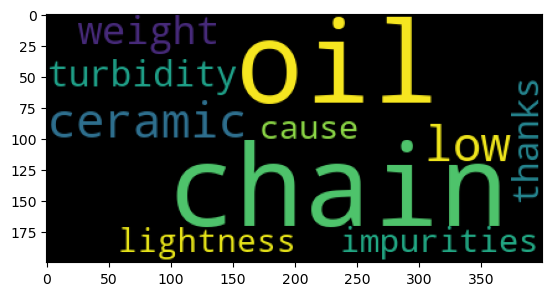

In [40]:
wc = WordCloud().fit_words(get_topic_dict(17))
plt.imshow(wc)

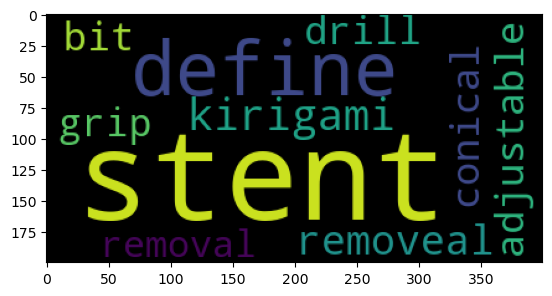

In [41]:
wc = WordCloud().fit_words(get_topic_dict(18))
plt.imshow(wc)